# Metrics-Based Impact Approximation

This notebook demonstrates **metrics-based impact approximation** using `evaluate_impact()`.

## Workflow Overview

1. User provides `products.csv`
2. User configures `DATA.ENRICHMENT` section
3. User calls `evaluate_impact(config.yaml)`
4. Engine handles everything internally (adapter, enrichment, transform, model)

## Setup

In [1]:
import json
from pathlib import Path

import pandas as pd
from impact_engine import evaluate_impact, parse_config_file
from impact_engine.core import apply_transform
from impact_engine.metrics import create_metrics_manager
from impact_engine.models.factory import get_model_adapter
from online_retail_simulator import simulate

## Step 1: Create Products Catalog

In production, this would be your actual product catalog.

In [2]:
output_path = Path("output/demo_metrics_approximation")
output_path.mkdir(parents=True, exist_ok=True)

job_info = simulate("configs/demo_metrics_approximation_catalog.yaml", job_id="catalog")
products = job_info.load_df("products")

print(f"Generated {len(products)} products")
print(f"Products catalog: {job_info.get_store().full_path('products.csv')}")
products.head()

Generated 100 products
Products catalog: /home/peisenha/office/business/eisenhauer-io/tools/impact-engine-measure/documentation/notebooks/output/demo_metrics_approximation/catalog/products.csv


,product_identifier,category,price
0,BPQLYSDULN,Toys & Games,63.59
1,BZUHJO3W06,Books,41.63
2,BUEH84ZKGX,Toys & Games,36.02
3,BHYTI0YWOG,Home & Garden,449.60
4,B5SXL65W5W,Toys & Games,17.28


## Step 2: Configure Metrics Approximation

Configure the impact engine with:
- **ENRICHMENT**: Quality boost parameters
- **TRANSFORM**: Prepare data for approximation
- **MODEL**: `metrics_approximation` with response function

In [3]:
config_path = "configs/demo_metrics_approximation.yaml"
baseline_config_path = "configs/demo_metrics_approximation_baseline.yaml"

## Step 3: Run Impact Evaluation

A single call to `evaluate_impact()` handles everything:
- Engine creates CatalogSimulatorAdapter
- Adapter simulates metrics
- Adapter generates product_details
- Adapter applies enrichment (quality boost)
- Transform extracts quality_before/quality_after
- MetricsApproximationAdapter computes impact

In [4]:
results_path = evaluate_impact(config_path, str(output_path), job_id="results")
print(f"Results saved to: {results_path}")

Results saved to: /home/peisenha/office/business/eisenhauer-io/tools/impact-engine-measure/documentation/notebooks/output/demo_metrics_approximation/results/impact_results.json


## Step 4: Review Results

In [5]:
with open(results_path) as f:
    results = json.load(f)

data = results["data"]
model_params = data["model_params"]
estimates = data["impact_estimates"]
summary = data["model_summary"]

print("=" * 60)
print("METRICS-BASED IMPACT APPROXIMATION RESULTS")
print("=" * 60)

print(f"\nModel Type: {results['model_type']}")
print(f"Response Function: {model_params['response_function']}")

print("\n--- Aggregate Impact Estimates ---")
print(f"Total Impact:        ${estimates['impact']:.2f}")
print(f"Number of Products:  {summary['n_products']}")

METRICS-BASED IMPACT APPROXIMATION RESULTS

Model Type: metrics_approximation
Response Function: linear

--- Aggregate Impact Estimates ---
Total Impact:        $3955.37
Number of Products:  100


In [6]:
# Per-product data is now in a separate parquet file (prefixed with model type)
results_dir = Path(results_path).parent
per_product_path = results_dir / "metrics_approximation__product_level_impacts.parquet"
per_product_df = pd.read_parquet(per_product_path)

print("\n--- Per-Product Breakdown (first 10) ---")
print("-" * 60)
print(f"{'Product':<20} {'Delta Quality':<15} {'Baseline':<12} {'Impact':<12}")
print("-" * 60)
for _, p in per_product_df.head(10).iterrows():
    print(
        f"{p['product_id']:<20} {p['delta_metric']:<15.4f} "
        f"${p['baseline_outcome']:<11.2f} ${p['impact']:<11.2f}"
    )

print("\n" + "=" * 60)
print("Demo Complete!")
print("=" * 60)


--- Per-Product Breakdown (first 10) ---
------------------------------------------------------------
Product              Delta Quality   Baseline     Impact      
------------------------------------------------------------
B00VJAJT3E           0.1020          $934.48      $47.66      
B025M9OIWD           0.1690          $685.25      $57.90      
B0L22EZJ3N           0.1750          $288.82      $25.27      
B0WRDZKKOD           0.0910          $75.90       $3.45       
B13A1TUGKH           0.1500          $27.48       $2.06       
B1EGT439P4           0.1810          $1012.38     $91.62      
B1UKZYGJXQ           0.2090          $277.60      $29.01      
B2NLGVE7RD           0.2020          $102.72      $10.37      
B32XK2XMWL           0.2150          $108.11      $11.62      
B3ZTQM667G           0.0710          $271.77      $9.65       

Demo Complete!


## Step 5: Truth Recovery Validation

Compare the model's estimate against the **true causal effect** computed from counterfactual vs factual data.

In [7]:
def calculate_true_effect(
    baseline_metrics: pd.DataFrame,
    enriched_metrics: pd.DataFrame,
) -> dict:
    """Calculate TRUE impact by comparing total revenue with vs without enrichment."""
    baseline_total = baseline_metrics["revenue"].sum()
    enriched_total = enriched_metrics["revenue"].sum()
    impact = enriched_total - baseline_total

    return {
        "baseline_total": float(baseline_total),
        "enriched_total": float(enriched_total),
        "impact": float(impact),
    }

In [8]:
parsed_baseline = parse_config_file(baseline_config_path)
baseline_manager = create_metrics_manager(parsed_baseline)
baseline_metrics = baseline_manager.retrieve_metrics(products)

parsed_enriched = parse_config_file(config_path)
enriched_manager = create_metrics_manager(parsed_enriched)
enriched_metrics = enriched_manager.retrieve_metrics(products)

print(f"Baseline records: {len(baseline_metrics)}")
print(f"Enriched records: {len(enriched_metrics)}")

Baseline records: 1400
Enriched records: 1400


In [9]:
true_effect = calculate_true_effect(baseline_metrics, enriched_metrics)

true_impact = true_effect["impact"]
model_impact = estimates["impact"]

if true_impact != 0:
    recovery_accuracy = (1 - abs(1 - model_impact / true_impact)) * 100
else:
    recovery_accuracy = 100 if model_impact == 0 else 0

print("=" * 60)
print("TRUTH RECOVERY VALIDATION")
print("=" * 60)
print(f"True impact:       ${true_impact:,.2f}")
print(f"Model estimate:    ${model_impact:,.2f}")
print(f"Recovery accuracy: {max(0, recovery_accuracy):.1f}%")
print("=" * 60)

TRUTH RECOVERY VALIDATION
True impact:       $1,342.93
Model estimate:    $3,955.37
Recovery accuracy: 0.0%


### Convergence Analysis

How does the estimate converge to the true effect as sample size increases?

In [10]:
sample_sizes = [5, 10, 25, 50, 100]
estimates_list = []
truth_list = []

parsed = parse_config_file(config_path)
transform_config = parsed["DATA"]["TRANSFORM"]
measurement_config = parsed["MEASUREMENT"]
all_product_ids = enriched_metrics["product_id"].unique()

for n in sample_sizes:
    subset_ids = all_product_ids[:n]
    enriched_sub = enriched_metrics[enriched_metrics["product_id"].isin(subset_ids)]
    baseline_sub = baseline_metrics[baseline_metrics["product_id"].isin(subset_ids)]

    true = calculate_true_effect(baseline_sub, enriched_sub)
    truth_list.append(true["impact"])

    transformed = apply_transform(enriched_sub, transform_config)
    model = get_model_adapter("metrics_approximation")
    model.connect(measurement_config["PARAMS"])
    result = model.fit(data=transformed)
    estimates_list.append(result.data["impact_estimates"]["impact"])

print("Convergence analysis complete.")

Convergence analysis complete.


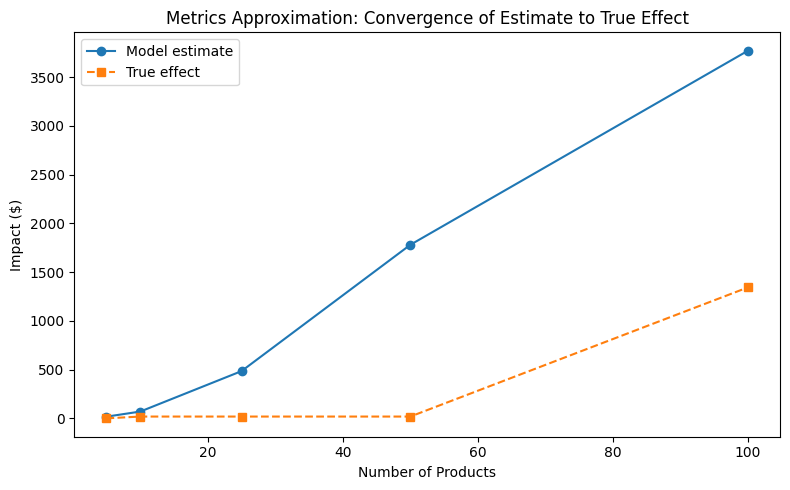

In [11]:
from notebook_support import plot_convergence

plot_convergence(
    sample_sizes,
    estimates_list,
    truth_list,
    xlabel="Number of Products",
    ylabel="Impact ($)",
    title="Metrics Approximation: Convergence of Estimate to True Effect",
)